In this post we will be using a method known as transfer learning in order to detect metastatic cancer in patches of images from digital pathology scans.

In [26]:
%matplotlib inline
import pandas as pd
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
plt.rcParams["figure.figsize"] = (5, 3) # (w, h)
plt.rcParams["figure.dpi"] = 200

## Data

The data we will be using is located on Kaggle in the dataset [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection/overview). There is a file `train_labels.csv` that contains all of the image names and classification labels. Lets load the CSV file in and take a look at the first few images:

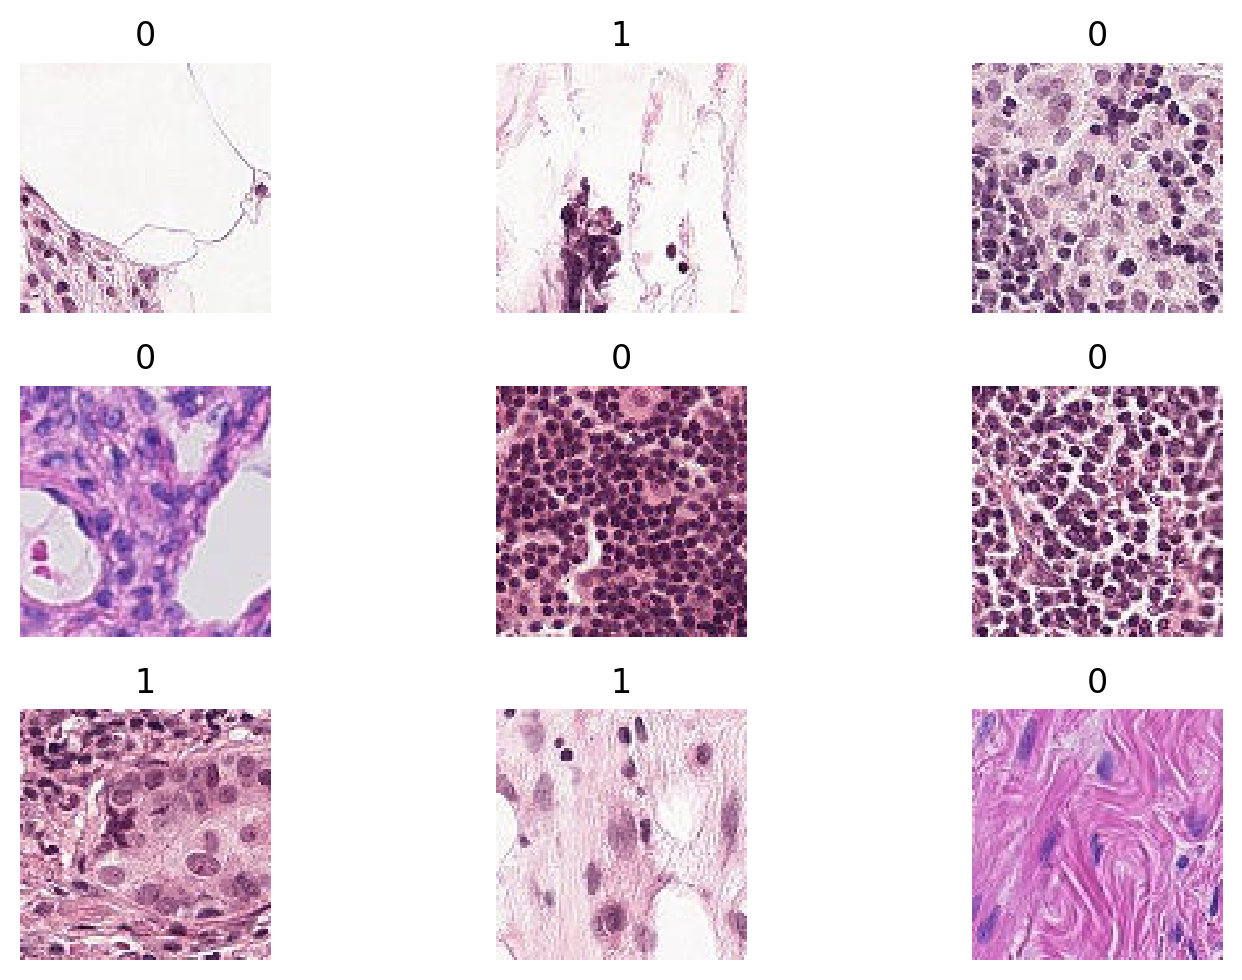

In [13]:
df = pd.read_csv("../data/train_labels.csv")
fig = plt.figure(figsize=(8,5))
for i in range(9):
    fig.add_subplot(3, 3, i + 1)
    fname = f"../data/train/{df.id[i]}.tif"
    plt.imshow(cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB))
    plt.title(df.label[i]); plt.axis("off")
fig.tight_layout()

In this dataset, an image is marked `1` if the center 32x32px region contains at least one pixel of tumor tissue. Otherwise, it is marked `0`. To the untrained eye, it is hard to notice any specific differences between the positive and negative images. Lucky for us, our computer will do all the hard work. Before we build are model, let's create a PyTorch DataSet that will allow us easily feed our images and labels into the model for training.

In [14]:
from torch.utils.data import DataLoader, Dataset

class HistopathologicDataset(Dataset):
    def __init__(self, df, datadir, transform=None):
        self.fnames = [f"{datadir}/{i}.tif" for i in df.id]
        self.labels = df.label.tolist()
        self.transform = transform
    
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, index):
        img = cv2.imread(self.fnames[index])
        if self.transform:
            img = self.transform(img)
        return img, self.labels[index]

### Transforms

Before we load our datasets, we will need to create a series of transforms. Transforms are used to convert the image into a format that our model can understand. We first ensure the image is the appropriate size, and then convert it convert it to a `Tensor`, which is a multi-dimensional matrix that can be used on both CPUs and GPUs. For our training set, we will use a few additional transforms that randomly flip and rotate the image. These random transforms help increase the diversity of our training set, a technique known as Data Augmentation.

In [15]:
from torchvision import transforms, models

normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.CenterCrop((49, 49)),
    transforms.ToTensor(),
    normalize,
])

valid_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop((49, 49)),
    transforms.ToTensor(),
    normalize,
])

Now we can load our datasets. We will load in 80% of the images as our training dataset, and use the other 20% to evaluate the model as it trains:

In [16]:
split = int(0.8 * len(df))
batch_size = 64
train_dataset = HistopathologicDataset(df[:split], "../data/train", train_transforms)
valid_dataset = HistopathologicDataset(df[split:], "../data/train", valid_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

## Model

Now that we have our datasets, we can build our model!

### Transfer Learning

Visual object recognition has been an ongoing problem within the computer vision community. As a result, researchers compete to produce state-of-the-art results on datasets such as [ImageNet](http://image-net.org) which consists of millions of images in 1000 object categories. One type of neural network architecture commonly used in the challenge is a [residual neural network (ResNet)](https://en.wikipedia.org/wiki/Residual_neural_network), and we can load a pre-trained version with just one line!

In [17]:
resnet = models.resnet50(pretrained=True)

Now we have a model that can accurately classify images of 1000 different objects, including everything from cats, to pencils, to airplanes. How does this help us with histopathologic tissue images? In the process of learning to distinguish between the different objects in ImageNet, the middle layers of the network learn to identify different features, such as lines, curves, and other patterns that help it make a prediction in the last layer. We can use these same features on our own dataset simply by replacing the last layer with a few layers of our own. This technique is known as *transfer learning*.

We'll be extending our ResNet with few layers outlined in the [fast.ai](https://course.fast.ai/part2) Deep Learning from the Foundations. If you are more interested in the inner workings of this model, I recommend you check it out!

In [18]:
from torch import nn

# https://docs.fast.ai/layers.html#AdaptiveConcatPool2d
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, size=1):
        super().__init__()
        self.output_size = size
        self.ap = nn.AdaptiveAvgPool2d(size)
        self.mp = nn.AdaptiveMaxPool2d(size)
        
    def forward(self, x):
        return torch.cat([self.mp(x), self.ap(x)], 1)

# https://docs.fast.ai/layers.html#Flatten
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)
    
in_features = resnet.fc.in_features * 2    
num_hidden = 512

head = nn.Sequential(
    AdaptiveConcatPool2d(1),
    Flatten(),
    nn.BatchNorm1d(in_features),
    nn.Dropout(0.5),
    nn.Linear(in_features=in_features, out_features=num_hidden),
    nn.ReLU(),
    nn.BatchNorm1d(num_hidden),
    nn.Dropout(0.5),
    nn.Linear(in_features=num_hidden, out_features=2),
)

model = nn.Sequential(
    nn.Sequential(*list(resnet.children())[:-2]),
    head
)

Now that we have created our model, we are ready for training.

## Training

First we'll need to specify that we'd like to use our GPU for training if possible. This will speed up the the training process by many orders of magnitude:

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Now we'll write a couple helper functions to train a batch of images, and compute the accuracy on the validation set:

In [20]:
def train(train_loader, model, criterion, optimizer, scheduler):
    total_loss = 0.0
    size = len(train_loader.dataset)
    num_batches = size // train_loader.batch_size
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        print(f"Training: {i}/{num_batches}", end="\r")
        
        scheduler.step()
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images) # forward pass
        loss = criterion(outputs, labels)
        total_loss += loss.item() * images.size(0)
        loss.backward()  # backprogagation
        optimizer.step()
        
    return total_loss / size

def validate(valid_loader, model, criterion):
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_loss = 0.0
        size = len(valid_loader.dataset)
        num_batches = size // valid_loader.batch_size
        for i, (images, labels) in enumerate(valid_loader):
            print(f"Validation: {i}/{num_batches}", end="\r")
            
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            total_correct += torch.sum(preds == labels.data)
            total_loss += loss.item() * images.size(0)
            
        return total_loss / size, total_correct.double() / size

Now we'll write our main training loop. For determining the learning rate of each training batch, we'll use a technique known as the 1 cycle policy. First outlined in Leslie Smith's [A disciplined approach to neural network hyper-parameters](https://arxiv.org/abs/1803.09820), the 1 cycle policy consists of training in two steps, first going from a low to high learning rate, second going from high to low. The result of this approach is a significantly reduced training time. At the time of writing there is an open [pull request](https://github.com/pytorch/pytorch/pull/21258) to implement the policy in PyTorch, but for now I will copy the code to `onecyclelr.py`

In [21]:
from onecyclelr import OneCycleLR

def fit(model, num_epochs, train_loader, valid_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
    scheduler = OneCycleLR(optimizer, max_lr=1e-2, train_dl=train_loader, num_epochs=num_epochs)
    print("epoch\ttrain loss\tvalid loss\taccuracy")
    for epoch in range(num_epochs):
        train_loss = train(train_loader, model, criterion, optimizer, scheduler)
        valid_loss, valid_acc = validate(valid_loader, model, criterion)
        print(f"{epoch}\t{train_loss:.5f}\t\t{valid_loss:.5f}\t\t{valid_acc:.3f}")

Now let's train for 20 epochs. We should be able to see the training loss, validation loss, and accuracy improve with each epoch:

In [22]:
model = model.to(device)
fit(model, 20, train_loader, valid_loader)

epoch	train loss	valid loss	accuracy
0	0.34798		0.27957		0.884
1	0.28280		0.26708		0.890
2	0.26309		0.22680		0.910
3	0.24658		0.21298		0.915
4	0.23179		0.21183		0.916
5	0.21783		0.19479		0.925
6	0.20712		0.22531		0.910
7	0.19530		0.19304		0.926
8	0.18516		0.19552		0.924
9	0.17654		0.19245		0.924
10	0.16677		0.19898		0.924
11	0.15686		0.20403		0.920
12	0.14875		0.19843		0.923
13	0.13865		0.17180		0.934
14	0.12790		0.17552		0.937
15	0.11589		0.17024		0.939
16	0.10216		0.16268		0.943
17	0.08672		0.16580		0.944
18	0.07534		0.16721		0.945
19	0.06741		0.16350		0.946


We can see that as the model trained, we achieved an accuracy of almost 95% in the validation set! Just like my [last post](2019/07/predicting-academic-collaboration-with-logistic-regression/), a better way of evaluating a model's diagnostic ability is by using the area under the [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve:

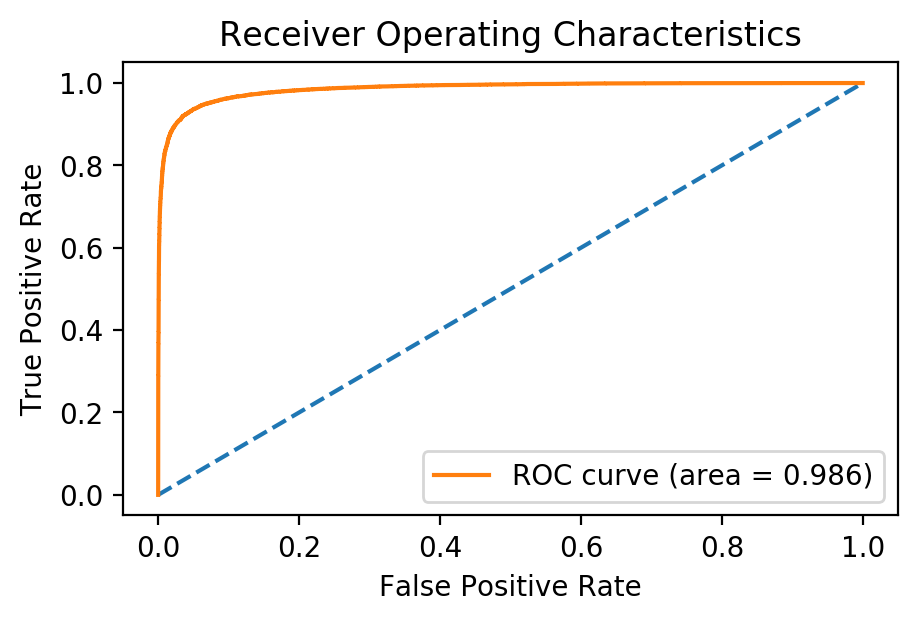

In [29]:
from sklearn.metrics import roc_curve, auc

def results(model, valid_loader):
    model.eval()
    preds = []
    actual = []
    with torch.no_grad():
         for images, labels in valid_loader:
            outputs = model(images.to(device))
            preds.append(outputs.cpu()[:,1].numpy())
            actual.append(labels.numpy())
    return np.concatenate(preds), np.concatenate(actual)

preds, actual = results(model, valid_loader)
fpr, tpr, _ = roc_curve(actual, preds)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, label=f"ROC curve (area = {auc(fpr, tpr):.3f})")
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics'); plt.legend();

We achieved an area under the ROC curve of 0.986 (best possible being 1.0), all by adding a few layers to a pre-trained model! This example serves as a testament as to how well transfer learning applied, even on data that is very different than the original model was trained on. The best part is, the same code can be used to apply transfer learning to a completely different image classification task. Feel free to copy my [notebook]() and try it for yourself!

If you liked this article, be sure to follow [@teddykoker](https://twitter.com/teddykoker), and check out my other [machine learning](/tags/machine-learning/) articles.